In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import random
import math
import time

import numpy as np
np.random.seed(1)
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.utils import np_utils
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping, History

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error


Using TensorFlow backend.


In [2]:
def prepare_training_data(df_F, df_D, df_Dt, d):
    
    DF = []
    for i in range(d):
        if i == 0:
            DF = np.concatenate((df_F.shift(d-i).values, df_D.shift(d-i).values, df_Dt.shift(d-i).values), axis = 1)
        else:
            DF = np.concatenate((DF, df_F.shift(d-i).values, df_D.shift(d-i).values, df_Dt.shift(d-i).values), axis=1)

    DF = DF[d:,:]
    Dy = np.concatenate((df_D.values, df_Dt.values), axis=1)
    Dy = Dy[d:,:]
    
    return DF, Dy

In [3]:
def train_test_split(DF, Dy, d, x_scaler, y_scaler):

    dim = np.shape(Dy)

    n_nodes = int(dim[1]/2)
    n_y = dim[1]
    x = np.linspace(0,1, n_nodes)

    #Scaling
    DFscaled = x_scaler.transform(DF)
    Dyscaled = y_scaler.transform(Dy)

    X_train = DFscaled
    Y_train = Dyscaled

    #Train test split
    train_portion = 0.8
    n_timesteps = len(X_train[:,0])
    x_train = X_train[0:int(n_timesteps*train_portion),:]
    x_test = X_train[int(n_timesteps*(train_portion)):,:]
    y_train = Y_train[0:int(n_timesteps*train_portion),:]
    y_test = Y_train[int(n_timesteps*(train_portion)):,:]

    n_features = int(x_train.shape[1]/d)
    
    #Reshape training data into 3D array as required by the LSTM layer
    #Input shape is: (n_timesteps, d, n_features)
    x_train = x_train.reshape((x_train.shape[0], d, n_features))
    x_test = x_test.reshape((x_test.shape[0], d, n_features))

    return x_train, x_test, y_train, y_test, n_nodes, n_features, n_y, x

In [15]:
def initialize_model(n_units, x_train, y_train, lr, n_layers):
    model = Sequential()
    
    #Add hidden layers, return_sequences=True if next layer is LSTM, False otherwise
    if n_layers == 1:
        model.add(LSTM(n_units, batch_input_shape=(1, x_train.shape[1], x_train.shape[2]), return_sequences=False, 
                       stateful=True))
        
    #elif n_layers == 2:
    #    model.add(LSTM(n_units, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
    #    model.add(LSTM(n_units))
    #else: 
    #    model.add(LSTM(n_units, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
    #    for layer in range(n_layers-1):
    #        model.add(LSTM(n_units, return_sequences = True))
    #    model.add(LSTM(n_units))
    
    
    #model.add(Dropout(0.1))
    
    model.add(Dense(len(y_train[0,:]))) #Output Layer
    adam = Adam(lr=lr)
    model.compile(loss='mae', optimizer=adam)
    
    #Define callbacks
    history = History()
    earlystop = EarlyStopping(monitor='loss', min_delta=0.0001, patience=20, verbose=1, mode='auto')
    callback_list = [earlystop, history]
    return model, callback_list

In [5]:
def get_error(predictions, y_test):
    #Squared error is integrated numerically in space for each timestep and summed
    error = 0
    for i in range(len(predictions[:,0])):
        error += np.trapz((y_test[i,:] - predictions[i,:])**2, x)
    return error

In [12]:
def independent_predictions(x_test):

    input_i = np.copy(x_test[0,:,:]) #Initial conditions
    input_i_reshaped = input_i.reshape((1,d,n_features)) #Reshape to fit LSTM layer

    future_timesteps = len(x_test[:,0,0])-1
    preds = np.zeros([future_timesteps, n_y])

    force = np.copy(x_test[:,:,:(n_nodes)]) #Loading history for future timesteps, which is known

    for i in range(future_timesteps): 
        pred = model.predict(input_i_reshaped) #Predict next timestep
        preds[i, :] = pred[0] 

        input_i[0:d-1,:] = input_i[1:d,:] #Move everything one step backward
        input_i[d-1,:n_nodes] = force[i+1,d-1,:] #Fill in force for next timestep
        input_i[d-1,n_nodes:] = pred[0] #Fill in values that we just predicted

        input_i_reshaped = input_i.reshape((1,d,n_features)) #Reshape to fit LSTM layer
        
    return preds

In [7]:
def get_scalers(DF, Dy):
    
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()
    
    x_scaler.fit_transform(DF)
    y_scaler.fit_transform(Dy)
    
    return x_scaler, y_scaler

In [17]:
def get_batch(x_train, y_train, batch_size):
    
    start = random.randint(0,len(x_train)-batch_size)
    
    x_batch = x_train[start:start+batch_size]
    y_batch = y_train[start:start+batch_size]
    
    return x_batch, y_batch

In [8]:
def get_batch_scalers(n_batches):
    
    #Simple version
    for i in range(n_batches):
        
        df_D = pd.read_csv('../training_batches/hD' + str(i+1) + '.csv')
        df_F = pd.read_csv('../training_batches/hF' + str(i+1) + '.csv')
        df_Dt = pd.read_csv('../training_batches/hDt' + str(i+1) + '.csv')
        
        if i == 0:  
            x_range = df_D.values.max() - df_D.values.min()
            imax = i
        
        else:
            new_x_range = df_D.values.max() - df_D.values.min()
            
            if new_x_range > x_range:
                x_range = new_x_range
                imax = i
                
    df_D = pd.read_csv('../training_batches/hD' + str(imax+1) + '.csv')
    df_F = pd.read_csv('../training_batches/hF' + str(imax+1) + '.csv')
    df_Dt = pd.read_csv('../training_batches/hDt' + str(imax+1) + '.csv')
    
    DF, Dy = prepare_training_data(df_F, df_D, df_Dt, d)
    x_scaler, y_scaler = get_scalers(DF, Dy)
    
    return x_scaler, y_scaler

In [9]:
#columns = ['training set', 'n_layers', 'height', 'epochs', 'batch size', 'learning rate', 'early stopping', 'stop loss', 'Training Error', 'Test Error',
#           'Ind test error', 'Ind train error', 'Training time', 'Total time']
#df = pd.DataFrame(columns = columns)

#df.to_csv('../results/RNN_velocity_results.csv')

In [24]:
######################### BATCH TRAINING ########################################

n_batches = 1
d = 10 

t0 = time.time()

x_scaler, y_scaler = get_batch_scalers(n_batches) #Get global scalers

#Hyperparameter settings
epochs = 100
layers = 1
height = 100
batch_size = 1000
lr = 0.0001

#Select training set
training_set = 'rr'

for iteration in range(n_batches):
    
    #Import training data
    df_D = pd.read_csv('../training_batches/'+ training_set +'D' + str(iteration+1) + '.csv')
    df_F = pd.read_csv('../training_batches/'+ training_set +'F' + str(iteration+1) + '.csv')
    df_Dt = pd.read_csv('../training_batches/'+ training_set +'Dt' + str(iteration+1) + '.csv')

    #Prepare training data
    DF, Dy = prepare_training_data(df_F, df_D, df_Dt, d)
    
    #Split into train and test set
    x_train, x_test, y_train, y_test, n_nodes, n_features, n_y, x = train_test_split(DF, Dy, d, x_scaler, y_scaler)
    
    
    model = Sequential()
    model.add(LSTM(height, batch_input_shape=(1, x_train.shape[1], x_train.shape[2]), return_sequences=False, 
                       stateful=False))
    model.add(Dense(len(y_train[0,:]))) #Output Layer
    adam = Adam(lr=lr)
    model.compile(loss='mae', optimizer=adam)
    
    n_batches = 23
    
    for epoch in range(epochs):
        ts = time.time()
        for n in range(n_batches):
            x_batch, y_batch = get_batch(x_train, y_train, batch_size)
            model.train_on_batch(x_batch, y_batch)
            
            #for m in range(batch_size):
            #    x_batch_i = x_batch[m].reshape(1,d,n_features)
            #    model.train_on_batch(x_batch_i, np.array([y_batch[m]]))
            
            #model.reset_states()
        
        pred_ind_all = independent_predictions(x_test)
        pred_ind = pred_ind_all[:, 0:n_nodes]
        ind_error = get_error(pred_ind, y_test[0:len(pred_ind[:,0]),0:n_nodes])
        
        epoch_time = time.time() - ts
        info = {'epoch': epoch, 'ind_error': ind_error, 'time': epoch_time}
        print(info)
        
        model.reset_states()
    
    
    
    

{'epoch': 0, 'ind_error': 121.05959763885345, 'time': 126.93040943145752}
{'epoch': 1, 'ind_error': 1318.2173553298196, 'time': 126.99242782592773}


KeyboardInterrupt: 

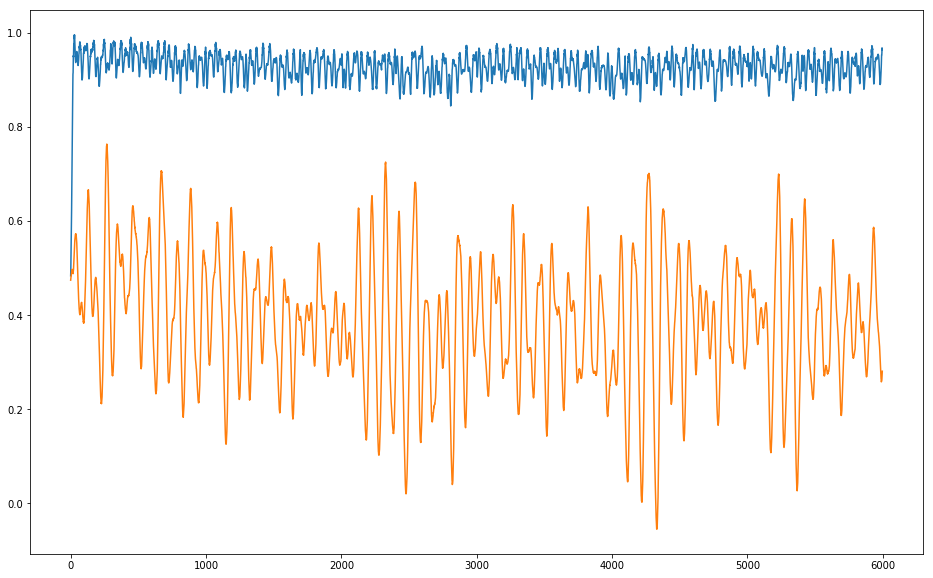

In [21]:
plt.figure(figsize=(16,10))
#plt.plot(pred_test[:,n_nodes-1], 'x')
plt.plot(pred_ind[:,n_nodes-1])
plt.plot(y_test[:, n_nodes-1])
plt.show()

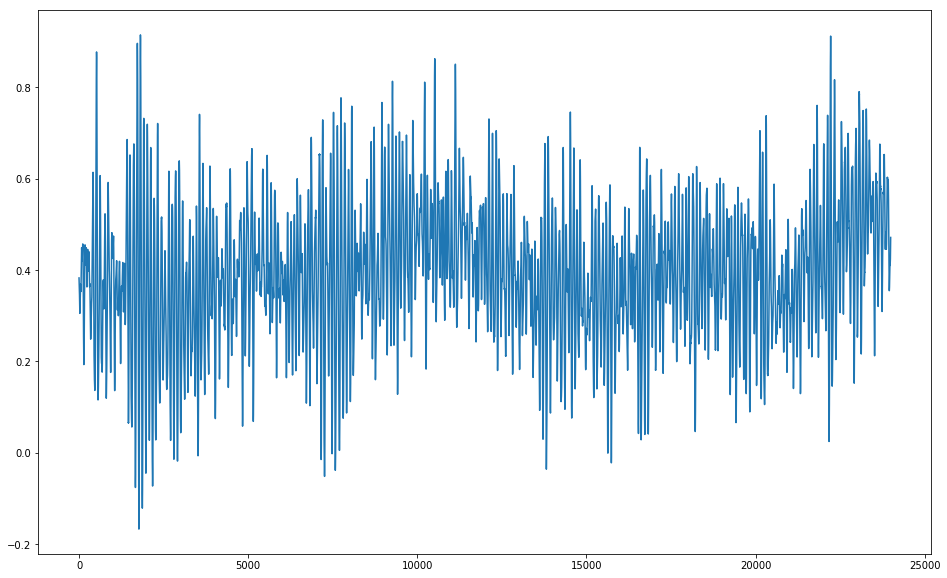

In [22]:
plt.figure(figsize=(16,10))
#plt.plot(pred_test[:,n_nodes-1], 'x')

plt.plot(y_train[:, n_nodes-1])
plt.show()

In [232]:
#df = df.drop(columns=df.columns[0])
#df.to_csv('../results/RNN_velocity_results.csv')

In [238]:
#pd.read_csv('../results/RNN_velocity_results.csv', index_col=0)
df

,training set,n_layers,height,epochs,batch size,learning rate,early stopping,stop loss,Training Error,Test Error,Ind test error,Ind train error,Training time,Total time
0,rr,2,100,500,1000,0.0005,115,0.005931,0.428430,0.102271,4.126604,19.038270,2173.341693,2263.469776
1,rr,2,100,500,1000,0.0001,36,0.005536,0.457434,0.111018,18.604378,96.249718,707.928417,803.638126
2,rr,3,50,500,1000,0.0005,160,0.013542,0.497549,0.108562,11.480535,70.656266,5234.750504,5392.588225
3,rr,3,100,500,1000,0.0005,278,0.004497,1.093541,0.246645,16.985114,97.339143,12917.886360,13195.994140


In [129]:
#save best model
#trained on= gr_set1

#model.save('../models/RNN_gr_set1.h5')

#### CONTINUE TRAINING ####
#model = load_model('beam_model.h5')

#model.fit(x_train, y_train, epochs=100, verbose=1)

#model.save('beam_model.h5')

#del(model)

In [20]:
######################### BATCH TESTING ########################################

n_batches = 1
#d = 8

t0 = time.time()
for iteration in range(n_batches):

    df_D = pd.read_csv('../training_batches/rrD' + str(iteration+1) + '.csv')
    df_F = pd.read_csv('../training_batches/rrF' + str(iteration+1) + '.csv')
    df_Dt = pd.read_csv('../training_batches/rrDt' + str(iteration+1) + '.csv')

    DF, Dy = prepare_training_data(df_F, df_D, df_Dt, d)
    
    #if i == 0:
    #    x_scaler, y_scaler = get_scalers(DF, Dy)
    
    x_train, x_test, y_train, y_test, n_nodes, n_features, n_y, x = train_test_split(DF, Dy, d, x_scaler, y_scaler)
    
    ts = time.time()
    #if i == 0:
    #    model, callback_list = initialize_model(100, x_train, y_train)
    
    #model.fit(x_train, y_train, epochs=100, callbacks=callback_list, batch_size=len(x_train), verbose=0, shuffle=False)
    
    training_time = time.time() - ts
    
    pred_train_all = model.predict(x_train)
    pred_train = pred_train_all[:, 0:n_nodes]
    pred_train_u = y_scaler.inverse_transform(pred_train_all)[:, 0:n_nodes]
    
    pred_test_all = model.predict(x_test)
    pred_test = pred_test_all[:, 0:n_nodes]
    pred_test_u = y_scaler.inverse_transform(pred_test_all)[:, 0:n_nodes]
    
    pred_ind_all = independent_predictions(x_test)
    pred_ind = pred_ind_all[:, 0:n_nodes]
    pred_ind_u = y_scaler.inverse_transform(pred_ind_all)[:, 0:n_nodes]
    
    y_test_u = y_scaler.inverse_transform(y_test)[:, 0:n_nodes]
    
    training_error = get_error(pred_train, y_train[:,0:n_nodes])
    test_error = get_error(pred_test, y_test[:,0:n_nodes])
    ind_error = get_error(pred_ind, y_test[0:len(pred_ind[:,0]),0:n_nodes])
    
    plt.figure(figsize=(16,10))
    #plt.plot(pred_test[:,n_nodes-1], 'x')
    plt.plot(pred_ind[:,n_nodes-1])
    plt.plot(y_test[:, n_nodes-1])
    plt.show()

    
    total_time = time.time() - t0
    
    info = {'Iteration number': iteration+1, 'Training Error': training_error, 'Test Error': test_error, 'Ind test error': ind_error,
            'Training time': training_time, 'Total time': total_time}
    print(info)

ValueError: In a stateful network, you should only pass inputs with a number of samples that can be divided by the batch size. Found: 23992 samples. Batch size: 32.

In [202]:
#Export results
np.savetxt("../results/predictions.csv", pred_test_u, delimiter=",")
np.savetxt("../results/preds.csv", pred_ind_u, delimiter=",")
np.savetxt("../results/y_test.csv", y_test_u, delimiter=",")
np.savetxt("../results/y_train.csv", y_test_u, delimiter=",")

In [203]:
pred_ind_all = independent_predictions(x_train)
pred_ind = pred_ind_all[:, 0:n_nodes]

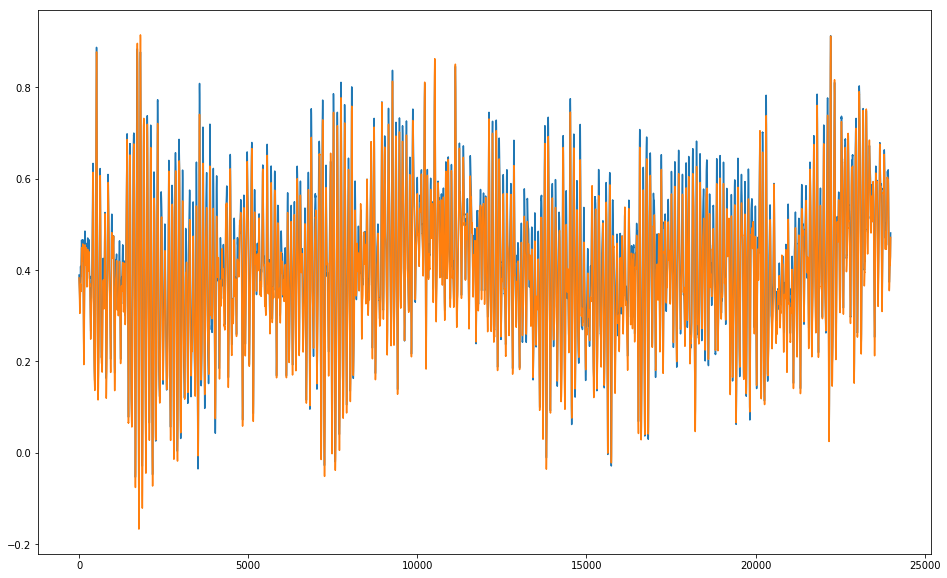

In [204]:
plt.figure(figsize=(16,10))
#plt.plot(pred_test[:,n_nodes-1], 'x')
plt.plot(pred_ind[:,n_nodes-1])
plt.plot(y_train[:, n_nodes-1])
plt.show()

In [89]:
DF.shape

(4995, 205)

In [91]:
df_D.values.shape

(5000, 21)

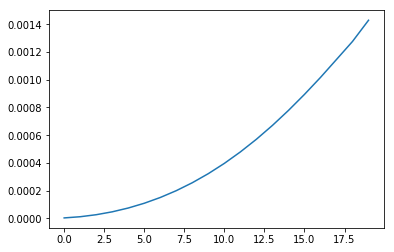

In [20]:
plt.plot(y_test_u[50,:])